## Preprocess Captions


In [1]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import Model, load_model
import numpy as np
from matplotlib import pyplot as plt
import os
from math import log
import pickle

In [2]:
def read_file(path):
    content = None
    with open(path) as f:
        content = f.read()
    return content

In [3]:
vocab = read_file('./Helper/vocabulary.txt')
vocab = eval(vocab)

captions = read_file('./Helper/captions.txt')
captions = eval(captions)

train_captions = read_file('./Helper/train_captions.txt')
train_captions = eval(train_captions)


In [4]:
print(type(train_captions))
print(type(captions))
print(type(vocab))

<class 'dict'>
<class 'dict'>
<class 'list'>


In [5]:
def create_mapping(vocab):
    
    word_to_index = {}
    index_to_word = {}
    
    for index,word in enumerate(vocab):
        word_to_index[word] = index + 1
        index_to_word[index + 1] = word
    
    index = len(word_to_index)
    word_to_index['<start>'] = index + 1
    index_to_word[index + 1] = '<start>'
    
    word_to_index['<end>'] = index + 2
    index_to_word[index + 2] = '<end>'
    
    return word_to_index,index_to_word

In [6]:
word_to_index,index_to_word = create_mapping(vocab)

In [7]:
index_to_word[200]

'ready'

In [8]:
with open('./Helper/word_to_index.pkl', 'wb') as f:
  pickle.dump(word_to_index, f)

In [9]:
with open('./Helper/index_to_word.pkl', 'wb') as f:
  pickle.dump(index_to_word, f)

In [10]:
def max_len_sentence(captions):
    max_length = 0
    
    for img_id in captions.keys():
        for caption in captions[img_id]:        
            max_length = max(max_length,len(caption.split()))
    
    return max_length

In [11]:
print(max_len_sentence(train_captions))

38


## Create Embedding

In [12]:
def create_embedding(vocab,word_to_index):
    embedding = {}
    with open('./Helper/glove.6B.50d.txt',encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            word_embedding = np.array(values[1:],dtype = 'float')
            embedding[word] = word_embedding
        
        embedding_dims = 50
        #print(embedding['apple'])
        embedding_matrix = np.zeros((len(vocab) + 3,embedding_dims)) ## +3 for start and end tokens
        
        for word in vocab:
            if word in embedding.keys():
                embedding_matrix[word_to_index[word]] = embedding[word]
        
        return embedding_matrix    

In [13]:
embedding_matrix = create_embedding(vocab,word_to_index)
print(embedding_matrix.shape)

(1854, 50)


## Data Loader/Generator

In [14]:
train_images = None
with open('./Helper/train_images.pkl', 'rb') as f:
  train_images = pickle.load(f)

In [15]:
def data_generator(train_captions,train_images,word_to_index,max_length,batch_size):
    
    X1,X2,Y = [],[],[]
    size = 1
    
    while True:
        
        for img_id,caption_list in train_captions.items():
            try:
                feature_vec = train_images[img_id]
            except:
                continue 
                
            for caption in caption_list:
                sequence = [word_to_index[word] for word in caption.split() if word in word_to_index]
                
                for i in range(1,len(sequence)):
                    
                    xi = sequence[0:i]
                    xi = pad_sequences([xi],maxlen = max_length,value = 0,padding = 'post')[0]
                    yi = sequence[i]
                    yi = to_categorical([yi],num_classes = len(vocab) + 3)[0] # +3 for tokens
                    
                    X1.append(feature_vec)
                    X2.append(xi)
                    Y.append(yi)
                    
                if size==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(Y)]
                    X1,X2,Y = [],[],[]
                    size = 1
            size += 1
    

## Model Architecture

In [16]:
def build_model(embedding_matrix,max_length,vocab_size,embedding_dims):
    
    ## smaller model 1
    image_input = Input(shape = (2048,)) ## NOTE : input given in batch but shape of one sample given
    L1 = Dropout(0.3)(image_input)
    image_encoding = Dense(256,activation = 'relu')(L1)
    
    ## smaller model 2
    caption_input = Input(shape = (max_length,))
    L2 = Embedding(input_dim = vocab_size + 3, output_dim = embedding_dims , mask_zero = True)(caption_input)
    L3 = Dropout(0.3)(L2)
    caption_encoding = LSTM(256)(L3)
    
    ##DECODE
    decoder = add([image_encoding,caption_encoding])
    L4 = Dense(256,activation='relu')(decoder)
    output = Dense(vocab_size + 3,activation='softmax')(L4)
    
    ## Combined Model
    model = Model(inputs = [image_input,caption_input], outputs = output)
    
    ## setting the embedding layer bu ourself and not training it
    model.layers[2].set_weights([embedding_matrix])
    model.layers[2].trainable = False
    
    return model

In [17]:
model = build_model(embedding_matrix,max_len_sentence(train_captions),len(vocab),50)
model.compile(loss='categorical_crossentropy',optimizer="adam")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 38, 50)    │     92,700 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 38, 50)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 38)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    314,368 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1854)      │    476,478 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,473,882 (5.62 MB)

 Trainable params: 1,381,182 (5.27 MB)

 Non-trainable params: 92,700 (362.11 KB)

## Training the Model

In [18]:
num_epochs = 10
batch_size = 3
steps = len(train_captions) // batch_size ## no of times generator to be called

In [22]:
def train():
    history = None
    for epoch in range(46,51):
        generator = data_generator(train_captions, train_images, word_to_index, max_len_sentence(train_captions), batch_size)
        history = model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
        model.save('./Model Weights/model_weights_' + str(epoch) + '.h5')
        
    return history

In [37]:
model = train()

In [29]:
model = load_model('./Model Weights/model_weights_50.h5')

In [25]:
test_images = None
with open('./Helper/test_images.pkl', 'rb') as f:
  test_images = pickle.load(f)

In [26]:
def predict(image, beam_width = 3, alpha = 0.7,max_len = max_len_sentence(train_captions)):
  l = [('<start>', 1.0)]
  for i in range(max_len):
    temp = []
    for j in range(len(l)):
      sequence = l[j][0]
      prob = l[j][1]
      if sequence.split()[-1] == '<end>':
        t = (sequence, prob)
        temp.append(t)
        continue
      encoding = [word_to_index[word] for word in sequence.split() if word in word_to_index]
      encoding = pad_sequences([encoding], maxlen = max_len, padding = 'post')
      pred = model.predict([image, encoding])[0]
      pred = list(enumerate(pred))
      pred = sorted(pred, key = lambda x: x[1], reverse = True)
      pred = pred[:beam_width]
      for p in pred:
        if p[0] in index_to_word:
            t = (sequence + ' ' + index_to_word[p[0]], (prob + log(p[1])) / ((i + 1)**alpha))
            temp.append(t)
    temp = sorted(temp, key = lambda x: x[1], reverse = True)
    l = temp[:beam_width]
  caption = l[0][0]
  caption = caption.split()[1:-1]
  caption = ' '.join(caption)
  return caption

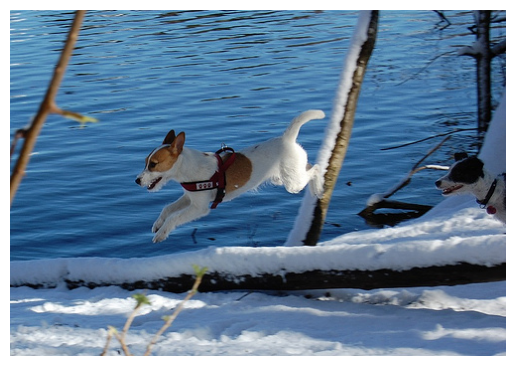

Actual caption:  a brown and white dog is leaping over a log near water in the snow 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/

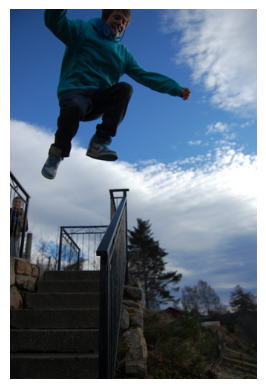

Actual caption:  a boy jumps off of an open air staircase 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

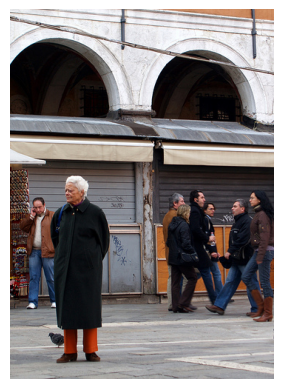

Actual caption:  a man is waiting in a public area while people pass behind him 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━

In [27]:

for i in range(3):
    index = np.random.randint(len(train_images))
    image_name = list(train_images.keys())[index]
    encoding = train_images[image_name]
    encoding = encoding.reshape((1, encoding.shape[0]))
    path = r'C:\\Users\Mukunda priya\Documents\Aaslesh\PROJECTS\AD 2\project\Image-Captioning\Dataset\Flickr8k_Dataset\Flicker8k_Dataset'
    image_path = path + "\\" + image_name + '.jpg'
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    actual_caption = captions[image_name]
    #print(image_name)
    print('Actual caption: ', actual_caption[0])
    predicted_caption = predict(encoding)
    print('Predicted caption: ', predicted_caption)

In [ ]:
predict("C:\Users\Mukunda priya\Documents\Aaslesh\PROJECTS\AD 2\project\Image-Captioning\Dataset\Flickr8k_Dataset\Flicker8k_Dataset\667626_18933d713e.jpg")